## 4. Writing reusable code

One of the most powerful features of earthkit-plots is the flexible templating system for generating titles, labels and even styles by gathering information from your data's metadata. This massively reduces the amount that you need to tweak your code when plotting new variables, timesteps, units or domains.

In this example we will be plotting some data from both GRIB and NetCDF formats to demonstrate that these features are *format agnostic*, which means that the same templates and metadata detection will work in exactly the same way for different input data formats (assuming they conform to sensible metadata standards!).

### Generic functions

Using these features we can write a simple function that will comfortably visualise many different kinds of input data, inferring plot elements like titles and styles directly from metadata.

In [1]:
import earthkit.data
import earthkit.plots


def my_plot(data, domain=None, units=None):
    chart = earthkit.plots.Map(domain=domain)

    chart.block(data, units=units)
    chart.coastlines()
    chart.gridlines()

    # The format keys between the curly braces will be populated from metadata
    chart.title("{variable_name} at {time:%H:%M on %-d %B %Y} over {domain}")

    # You can also use metadata format strings in legend labels
    chart.legend(label="{variable_name} ({units})")

    chart.show()

Now let's try plotting some temperature data in NetCDF format over Australia using this function.

era5-hourly-2t-20230724T1200Z.nc:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

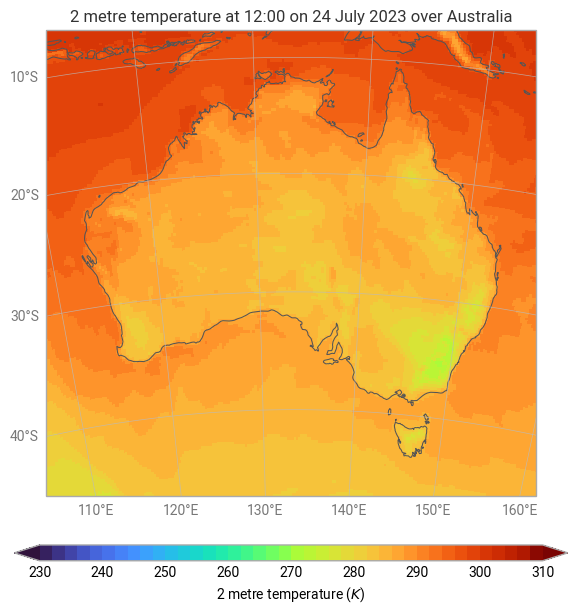

In [2]:
data_2t = earthkit.data.from_source("sample", "era5-hourly-2t-20230724T1200Z.nc")
my_plot(data_2t, domain="Australia")

Under-the-hood, *earthkit-data* is able to understand NetCDF CF-compliant metadata, and can replace our title's format keys (like `"{variable_name}"` and `"{time}"`) with the values it finds inside the data.

<div class="alert alert-block alert-info">
<h4>Where did the colours and levels come from?</h4>
<p>
When you plot some data without passing any style information, earthkit-plots will check your data's metadata to see if it can identify the quantity that's being visualised. If so, a default style, designed for use with the given quantity, will be automatically used. In the above case, earthkit-plots was able to identify that the quantity being visualised was 2m temperature in Kelvin, for which it has a pre-defined style that can be used.
</p>
<p>
This behaviour can be switched off with:<br>
<code>earthkit.plots.schema.automatic_styles = False</code>
</p>
</div>

Now let's use exactly the same code template, but for some different data, which:
- Comes from a GRIB file instead of a NetCDF file
- Contains sea surface temperature instead of 2m temperature
- Has a different time step

Let's also change a few things about the plot, like:
- Changing the domain to Australia
- Enforcing our own units of choice (celsius)

era5-hourly-sst-19931216T0000Z.grib:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

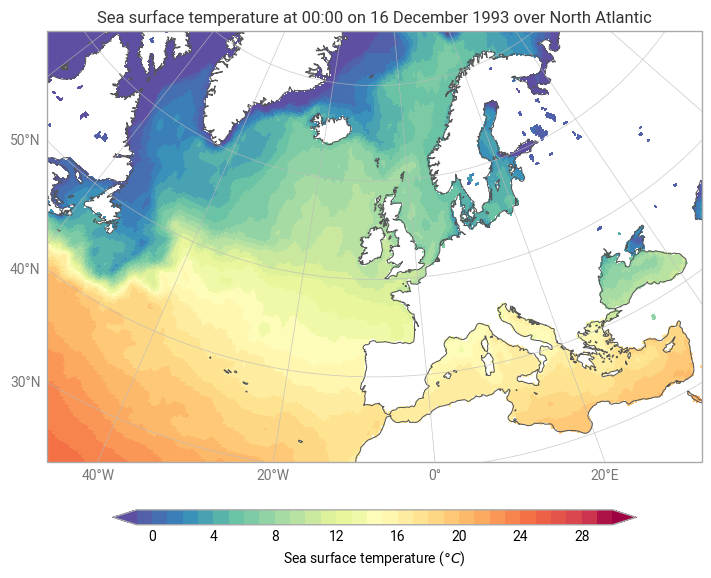

In [3]:
data_sst = earthkit.data.from_source("sample", "era5-hourly-sst-19931216T0000Z.grib")
my_plot(data_sst, domain="North Atlantic", units="celsius")

Voilà! We didn't need to write a new function to visualise this new data - earthkit-plots was able to generate a new title, colour scheme and legend label based solely on the data's metadata. Even though we plotted a GRIB file this time, which has a different structure and metadata standards to NetCDF, earthkit-plots was still able to use the exact same template.

### Valid format keys

Titles and labels in earthkit-plots can be populated with any standard metadata that can be found inside your data. This means something slightly different for different data formats - for example, for NetCDF, this means all global and variable attributes - but is designed to look in the most likely place for each different file format.

There are also some "magic" keys in earthkit-plots, which attempt to do something a bit smarter than simply extracting a value directly from your metadata. Here are a few of the most useful magic keys:
- `{variable_name}` - this will attempt to find the most human-readable version of the variable name from your metadata, by simply iterating through a priority list of attributes which normally represent variable names
- `{time}` - if your data only has one time dimension, this is how to access it; if your data has a base time and validity time, then the `{time}` will represent the *validity time*, but note that you can also explicity ask for the `{valid_time}` too
- `{lead_time}` - the number of hours between the forecast reference time / base time and the validity time
- `{units}` - if you plot your data with a style that is tied to some units, then this key will show the units of your plot; otherwise this is simply the units of your data.